## 2. Un problema* Multi-label*
>a) Cargue los datos del output del modelo (labels), descríbalos ¿Cuántos ejemplos hay por cada clase?

In [1]:
import pandas as pd
import numpy as np


label_names = np.loadtxt("ConceptsList/Concepts81.txt",dtype='object')

y = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None).values

print(y.shape)


labels=zip(label_names,y.sum(axis=0))
for label,num in labels:
    print(label,"=",num)

C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


(27807, 81)
airport = 342
animal = 2968
beach = 2097
bear = 68
birds = 471
boats = 1551
book = 11
bridge = 717
buildings = 4652
cars = 348
castle = 172
cat = 113
cityscape = 830
clouds = 15538
computer = 27
coral = 363
cow = 199
dancing = 44
dog = 237
earthquake = 8
elk = 116
fire = 151
fish = 346
flags = 40
flowers = 615
food = 70
fox = 58
frost = 247
garden = 802
glacier = 187
grass = 4933
harbor = 243
horses = 322
house = 1398
lake = 5758
leaf = 153
map = 3
military = 726
moon = 240
mountain = 2098
nighttime = 1031
ocean = 4659
person = 3329
plane = 693
plants = 2717
police = 203
protest = 60
railroad = 232
rainbow = 128
reflection = 3235
road = 2031
rocks = 2054
running = 99
sand = 549
sign = 97
sky = 19052
snow = 1275
soccer = 29
sports = 245
statue = 94
street = 557
sun = 1529
sunset = 3320
surf = 79
swimmers = 90
tattoo = 18
temple = 294
tiger = 48
tower = 667
town = 774
toy = 140
train = 230
tree = 1340
valley = 1682
vehicle = 1522
water = 11019
waterfall = 122
wedding = 144
wh

Hay 27807 datos en total, con 81 clases distintas, estas siendo de distinto tipo, como piedras, solv, vehiculo o animal.

>b) Visualice el tema de que un dato (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema multi-label y cómo aplica en este caso.

Etiquetas de la imagen : ['clouds' 'flowers' 'ocean' 'plants']


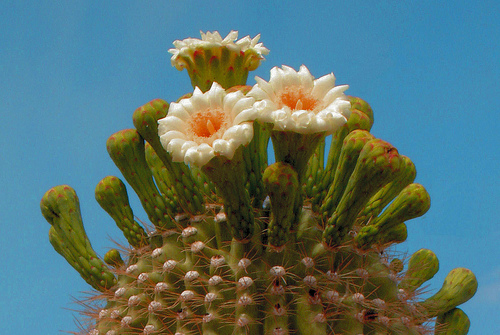

In [5]:
import urllib.request,re
label_names = np.loadtxt("ConceptsList/Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib.request.urlopen(data_urls[s]))
im


>c) Comente sobre la representación que posee la salida de los modelos (labels) ¿En qué dominio habita? ¿Tiene restricciones?

Matematicamente hablando para un conjunto de etiquetas $L$ , un multilabel es un elemento $x\in \mathcal{P}(L)$, donde $\mathcal{P}$ es el conjunto potencia, es decir, un multilabel es un subconjunto de todos los labels. El tamaño de este dominio es $| \mathcal{P}(L)|=2^{|L|}$, para este caso en especifico, con $|L|=81$, $| \mathcal{P}(L)|=2^{81}\cong 2.4 \times10^{24}$, por lo tanto estamos en un caso de alta dimensionalidad.
Por otro lado, el dominion no tiene restricciones explicitas, ya que una foto puede tener contenido que sea de cualquier etiqueta, sin embargo, hay restricciones practicas para cierto tipo de contenido, por ejemplo, una fotografia no podria tener las 81 clases al mismo tiempo ya que son conceptos tan distintos entre ellos que es infeasible que exista tal, o la etiqueta perro implica que esta la etiqueta animal.

>d) Decida sobre una representación, en este caso descriptores, para la entrada a los modelos (input), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.

El dataset viene con distintas opciones de descriptores, entre ellos:

Histograma de colores: 
Para el espacio de colores LAB (Lightness, A rojo-verde, B azul-amarillo)(esta es una representacion de los colores parecida RGB, CMYK), se hace un histograma de la distribucion de los colores de una imagen en K bins, dado por $h(i)=\frac{n_i}{N}\quad i=1,...,K$, donde $h(i)$ es el numero de pixeles con valor $i$, $N$ la cantidad de pixeles en la imagen. Para este caso se toma $K=4$, por lo tanto la dimension es $64=4^3$, por los 3 canales.

Auto-Correlograma de colores: 
Se construye otro espacio tridimencional donde las primeras dos componentes de un dato estan dadas por los colores de cualquier par de pixeles, y la ultima componente por su distancia en la imagen. Para la implentacion de este caso los colores se agrupan en 36 bins y las distancias en 4 intervalos, por lo tanto la dimension es $144=36\times 4$

Histograma de direccion de bordes:
Luego de particionar la imagen en sub bloques, se cuentan la cantidad de bordes, se construye un histograma con 72 bins dependiendo si un borde esta en un intervalo de 5 grados ($5\times72=360$), tambien se agrega 73-esimo componente dependiendo si el borde no tiene una direccion definida. Asi la dimension es $73$

Momentos de colores por bloque:
La imagen se divide en sub bloques de $5\times 5$, luego, para cada color, se calculan los tres primeros momentos estadisticos (media, varianza y skewness(asimetria)) en cada sub bloque, esto da un total de $3\times 3\times 5\times5=225$ dimensiones.

Se utilizara el histograma de colores para esta actividad, ya que es la mas simple teoricamente.

In [6]:
file = "Normalized_CH_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None).values
descriptors.shape


C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


(27807, 64)

>e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

 

>f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las labels que tenga un dato de manera normalizada. Defina otra métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).

In [15]:
def evaluation_metric(y_true,y_pred):
    suma = 0.

    for y,yp in zip(y_true,y_pred):
        if np.sum(y)!=0:                     #hay imagenes sin etiquetas
            suma += np.sum(y==yp, dtype='float')/len(y)  #cantidad de valores iguales

    return suma/float(len(y_true))



Se implementa el indice de Jaccard, definida para un dato como $J(y,\hat{y})=\dfrac{|y\cup\hat{y}|}{|y\cap\hat{y}|}$, donde la union y la interseccion se hace termino ha termino del vector booleano y, $|\cdot|$ es la cantidad de elementos verdaderos. Este indice es igual a 1 si y solo si $y=\hat{y}$, e igual a 0 si y solo si no tienen elementos en comun $y$ e $\hat{y}$

In [16]:
def jaccard(y_true, y_pred):

    t_or_p = np.count_nonzero(y_true + y_pred, axis=1) #la suma preserva la cardinalidad de la union
    t_and_p = np.count_nonzero(np.multiply(y_pred,y_true), axis=1)#el producto preserva la cardinalidad de la interseccion
    score = t_and_p / t_or_p
    score[t_or_p == 0.0] = 1.0

    return np.mean(score)

>g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de sklearn se puede extender de manera sencilla a multi-label [4]. Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.

In [17]:

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as Tree
indice_test=[]
indice_train=[]
metric_test=[]
metric_train=[]
for depth in range(1,20):
    model = Tree() 
    model.set_params(max_depth=depth,criterion='gini',splitter='best')
    model.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    metric_test.append(evaluation_metric(y_test,y_pred_test))
    metric_train.append(evaluation_metric(y_train,y_pred_train))
    
    indice_test.append(jaccard(y_test,y_pred_test))
    indice_train.append(jaccard(y_train,y_pred_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5:

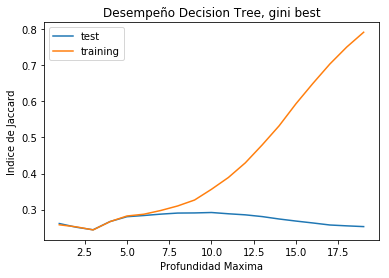

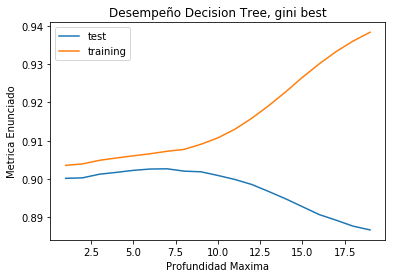

In [18]:
plt.title("Desempeño Decision Tree, gini best")
plt.xlabel("Profundidad Maxima")
plt.ylabel("Indice de Jaccard")

plt.plot(range(1,20),indice_test,label="test")
plt.plot(range(1,20),indice_train,label="training")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree, gini best")
plt.xlabel("Profundidad Maxima")
plt.ylabel("Metrica Enunciado")

plt.plot(range(1,20),metric_test,label="test")
plt.plot(range(1,20),metric_train,label="training")
plt.legend(loc="best")
plt.show()

Utilizando un arbol de decision, con criterio gini y particion best, y variando la profundida maxima se obtienen los resultados mostrados. Se aprecia que es leve la diferencia entre ambas metricas, y que el overfitting empieza a ser relevante a la profundidad maxima 8 aproximadamente, lo que es coherente con la teoria ya que hay una mayor cantidad de variables libres en el modelo. Por otro lado, en promedio ambas metricas obtienen el valor de 0.3, que es demasiado bajo, se experimenta con el criterio de entropia

In [13]:
indice_test=[]
indice_train=[]
metric_test=[]
metric_train=[]
for depth in range(1,20):
    model = Tree() 
    model.set_params(max_depth=depth,criterion='entropy',splitter='best')
    model.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    metric_test.append(evaluation_metric(y_test,y_pred_test))
    metric_train.append(evaluation_metric(y_train,y_pred_train))
    
    indice_test.append(jaccard(y_test,y_pred_test))
    indice_train.append(jaccard(y_train,y_pred_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5:

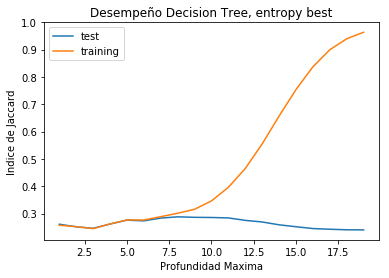

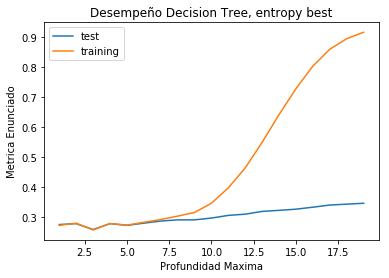

In [14]:
plt.title("Desempeño Decision Tree, entropy best")
plt.xlabel("Profundidad Maxima")
plt.ylabel("Indice de Jaccard")

plt.plot(range(1,20),indice_test,label="test")
plt.plot(range(1,20),indice_train,label="training")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño Decision Tree, entropy best")
plt.xlabel("Profundidad Maxima")
plt.ylabel("Metrica Enunciado")

plt.plot(range(1,20),metric_test,label="test")
plt.plot(range(1,20),metric_train,label="training")
plt.legend(loc="best")
plt.show()

Al utilizar entropy como criterio de separacion, se obtienen resultados similares,(overfitting para profundidad maxima mayor a 8, y metrica promedio de 3). Se concluye que un arbol de decision no es el mejor metodo a utilizar 

>h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de sklearn se puede extender a multi-label a través de la técnica OneVsRest. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.

In [21]:
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier

X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.95)

indice_test=[]
indice_train=[]
metric_test=[]
metric_train=[]

ragomin=-2
ragomax=1

espaciolog=np.logspace(ragomin,ragomax,base=10,num=10)

for C in espaciolog:
    model= SVM()
    model.set_params(C=C,kernel='rbf')
    meta_model = OneVsRestClassifier(model)
    meta_model.fit(X_train,y_train)
    
    y_pred_test = meta_model.predict(X_test)
    y_pred_train = meta_model.predict(X_train)
    
    metric_test.append(evaluation_metric(y_test,y_pred_test))
    metric_train.append(evaluation_metric(y_train,y_pred_train))
    
    indice_test.append(jaccard(y_test,y_pred_test))
    indice_train.append(jaccard(y_train,y_pred_train))
    
    


C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 19 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 36 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 57 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 65 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning:

C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 36 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 57 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 65 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
C:\Users\Ignacio\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 17 is pre

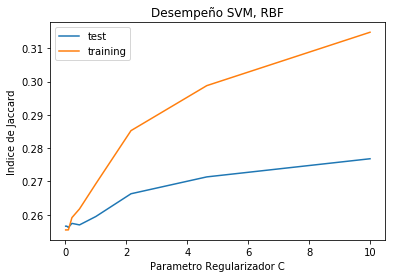

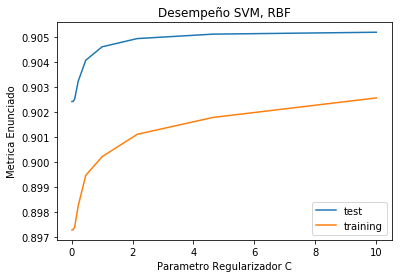

Cantidad de datos de entrenamiento: 1390


In [22]:
    
plt.title("Desempeño SVM, RBF")
plt.xlabel("Parametro Regularizador C")
plt.ylabel("Indice de Jaccard")

plt.plot(espaciolog,indice_test,label="test")
plt.plot(espaciolog,indice_train,label="training")
plt.legend(loc="best")
plt.show()

plt.clf()

plt.title("Desempeño SVM, RBF")
plt.xlabel("Parametro Regularizador C")
plt.ylabel("Metrica Enunciado")

plt.plot(espaciolog,metric_test,label="test")
plt.plot(espaciolog,metric_train,label="training")
plt.legend(loc="best")
plt.show()
print("Cantidad de datos de entrenamiento:",len(X_train))

Primero que todo, debido a razones computo se redujo los datos de entrenamiento a 1390, luego, se entreno una SVM con kernel RBF variando el parametro C entre $10^-2$ y $10$, este rango tambien por temas computacionales. Es importante notar que la reduccion del conjunto de entrenamiento implico que muchas etiquetas no aparecieran, esto significa que el modelo pierde informacion fundamental de entrenamiento.

Para este caso con la metrica propuesta se obtienen resultados satisfactorios,  esta está bordeando el valor 0.9 para el conjunto de testeo y entrenamiento, se podria decir que hay un underfitting, sin embargo debido a que la diferencia entre ambos valores es de a lo mas 0.02 no se estima conveniente. El comportamiento del indice de jaccard es similar al caso de arboles de decision, este bordeando el valor 0.3 y hay un overfitting que aumenta para mayores valores de C.

>i) Experimente en resolver el problema con una Red Neuronal Feed Forward (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a multi-label a través de la interfaz de keras seleccionando una loss adecuada, en este caso binary cross entropy ¿Por qué?

Primero, es importante notar que es necesario ocupar el error "categorical cros entropy", debido a que es una clasificacion no binaria. Se compara entre una red con 10 neuronas en una capa escondida y otra con cuantro capas escondidas de 1000 neuronas cada una, esto con el fin de tener una idea de la complejidad y la cantidad de parametros libres necesarios.

In [100]:
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)




Epoch 1/20
18630/18630 [==============================] - 1s 31us/step - loss: 18.3729
Epoch 2/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.9991
Epoch 3/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.6897
Epoch 4/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.3746
Epoch 5/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.0085
Epoch 6/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.5402
Epoch 7/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.9311
Epoch 8/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.2703
Epoch 9/20
18630/18630 [==============================] - 0s 4us/step - loss: 14.7382
Epoch 10/20
18630/18630 [==============================] - 0s 4us/step - loss: 14.3884
Epoch 11/20
18630/18630 [==============================] - 0s 4us/step - loss: 14.2042
Epoch 12/20
18630/18630 [==========================

In [103]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(1000, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(1000, activation="relu"))
model.add(Dense(1000, activation="relu"))
model.add(Dense(1000, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)



Epoch 1/20
18630/18630 [==============================] - 4s 225us/step - loss: 17.7534
Epoch 2/20
18630/18630 [==============================] - 4s 192us/step - loss: 14.7992
Epoch 3/20
18630/18630 [==============================] - 4s 188us/step - loss: 14.2077
Epoch 4/20
18630/18630 [==============================] - 4s 189us/step - loss: 14.0245
Epoch 5/20
18630/18630 [==============================] - 4s 188us/step - loss: 13.8300
Epoch 6/20
18630/18630 [==============================] - 4s 189us/step - loss: 13.6538
Epoch 7/20
18630/18630 [==============================] - 4s 188us/step - loss: 13.5086
Epoch 8/20
18630/18630 [==============================] - 3s 187us/step - loss: 13.4049
Epoch 9/20
18630/18630 [==============================] - 3s 188us/step - loss: 13.3900
Epoch 10/20
18630/18630 [==============================] - 4s 188us/step - loss: 13.3067
Epoch 11/20
18630/18630 [==============================] - 3s 187us/step - loss: 13.2723
Epoch 12/20
18630/18630 [=====

Comparando entre ambas redes, se aprecia que basta ocupar 10 neuronas por la leve diferencia en el error tras 20 epochs y la velocidad de computo. Luego, se experimenta entre funciones de activacion relu y sigmoidales.

In [106]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(y_train.shape[1], activation="relu"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)



Epoch 1/20
18630/18630 [==============================] - 1s 36us/step - loss: 18.0080
Epoch 2/20
18630/18630 [==============================] - 0s 4us/step - loss: 18.8211
Epoch 3/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.6162
Epoch 4/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.3816
Epoch 5/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.8921
Epoch 6/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.5921
Epoch 7/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.3766
Epoch 8/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.3065
Epoch 9/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.1424
Epoch 10/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.2986
Epoch 11/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.6015
Epoch 12/20
18630/18630 [==========================

In [107]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


Epoch 1/20
18630/18630 [==============================] - 1s 36us/step - loss: 18.2915
Epoch 2/20
18630/18630 [==============================] - 0s 5us/step - loss: 17.6320
Epoch 3/20
18630/18630 [==============================] - 0s 4us/step - loss: 17.2596
Epoch 4/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.9576
Epoch 5/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.6788
Epoch 6/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.4098
Epoch 7/20
18630/18630 [==============================] - 0s 4us/step - loss: 16.1489
Epoch 8/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.9001
Epoch 9/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.6691
Epoch 10/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.4610
Epoch 11/20
18630/18630 [==============================] - 0s 4us/step - loss: 15.2782
Epoch 12/20
18630/18630 [==========================

In [108]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(Dense(y_train.shape[1], activation="relu"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


Epoch 1/20
18630/18630 [==============================] - 1s 37us/step - loss: 24.7505
Epoch 2/20
18630/18630 [==============================] - 0s 4us/step - loss: 22.1118
Epoch 3/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.6203
Epoch 4/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.4508
Epoch 5/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.3728
Epoch 6/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.3788
Epoch 7/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.2496
Epoch 8/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.1707
Epoch 9/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.1306
Epoch 10/20
18630/18630 [==============================] - 0s 4us/step - loss: 21.0602
Epoch 11/20
18630/18630 [==============================] - 0s 4us/step - loss: 20.9485
Epoch 12/20
18630/18630 [==========================

Al que ocupar Relu y luego sigmoid se obtiene la menor perdida de 12.9871, esto implica mejores resultados utilizando estas funciones de activacion, se considero utilizar softmax como funcion de activacion en la ultima capa, sin embargo se desconoce el comportamiento para multilabel asi que se decidio finalmente que no.

In [26]:
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="categorical_crossentropy")
model.fit(X_train, y_train, epochs=20, batch_size=1000, verbose=1)

model.summary()

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

C:\Users\Ignacio\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
18630/18630 [==============================] - 0s 8us/step - loss: 18.2849
Epoch 2/20
18630/18630 [==============================] - 0s 3us/step - loss: 17.8525
Epoch 3/20
18630/18630 [==============================] - 0s 3us/step - loss: 17.4581
Epoch 4/20
18630/18630 [==============================] - 0s 3us/step - loss: 17.0426
Epoch 5/20
18630/18630 [==============================] - 0s 3us/step - loss: 16.5503
Epoch 6/20
18630/18630 [==============================] - 0s 3us/step - loss: 15.9433
Epoch 7/20
18630/18630 [==============================] - 0s 3us/step - loss: 15.3096
Epoch 8/20
18630/18630 [==============================] - 0s 3us/step - loss: 14.7971
Epoch 9/20
18630/18630 [==============================] - 0s 3us/step - loss: 14.4319
Epoch 10/20
18630/18630 [==============================] - 0s 3us/step - loss: 14.1803
Epoch 11/20
18630/18630 [==============================] - 0s 3us/step - loss: 14.0105
Epoch 12/20
18630/18630 [===========================

> j) Realice predicciones probabilísticas de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de labels categoricos definidos como en c).
Hint: Recuerde que el no pertenecer a ninguna label/etiqueta es una posibilidad!!

In [125]:
prob_pred_test = model.predict(X_test)
prob_pred_train = model.predict(X_train)

y_pred_test = np.rint(prob_pred_test) 
y_pred_train = np.rint(prob_pred_train) #redondeo al entero mas cercano

Las probabilidades ya vienen normalizadas por keras, luego simplemente se dice que una imagen tiene cierta etiqueta si es que  el valor de esta etiqueta es mayor que 0.5

k) Ahora que recuperó la representación de las labels mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

In [126]:
print(evaluation_metric(y_test,y_pred_test))
print(evaluation_metric(y_train,y_pred_train))

print(jaccard(y_test,y_pred_test))
print(jaccard(y_train,y_pred_train))

0.3871159602689532
0.38977982594729355
0.3160554363970513
0.31849595907164346


Las metricas no obtuvieron un cambio sustantivo al utilizar redes neuronales, lo mas probable es debido a que la representacion utilizada no era la adecuada, es decir, esta no codificaba adecuadamente la informacion de las etiquetas.

Etiquetas de la imagen reales: ['clouds' 'flowers' 'ocean' 'plants']
Etiquetas de la imagen predicha: ['clouds' 'sky' 'water']


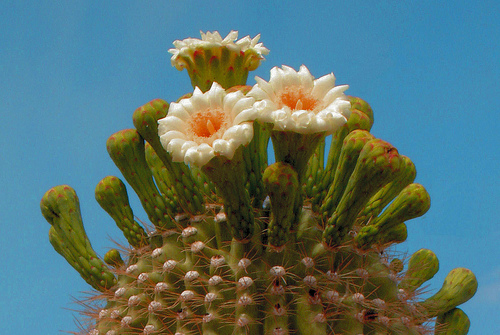

In [54]:
inputdata = np.array([descriptors[s]])
prediccion=np.rint(model.predict(inputdata))
print("Etiquetas de la imagen reales:",label_names[category_sample])
print("Etiquetas de la imagen predicha:",label_names[np.nonzero(prediccion)[1]])
im = Image.open(urllib.request.urlopen(data_urls[s]))
im

Para el caso particular de la imagen de ejemplo es claro que las etiquetas asignadas son coherentes a la imagen. De todos modos podria existir alguna otra etiqueta que mejor describe a la imagen, sin embargo, a partir de este ejemplo se obtienen resultados satisfactorios.